In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import geopy.geocoders
from geopy.geocoders import Nominatim, GoogleV3
from sklearn.linear_model import LinearRegression
import numpy as np
import re
import config
from geopy import distance

%matplotlib inline
pd.set_option('display.max_colwidth', -1) #setting used to display the full links properly

In [62]:
#instantiate geocoder
geolocator = Nominatim(user_agent='my_app/1')
geolocator_google = GoogleV3(api_key=config.gmaps_api_key)

## Read file and clean variables

In [52]:
#read csv
df = pd.read_csv('data/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68161 entries, 0 to 68160
Data columns (total 11 columns):
month                  68161 non-null object
town                   68161 non-null object
flat_type              68161 non-null object
block                  68161 non-null object
street_name            68161 non-null object
storey_range           68161 non-null object
floor_area_sqm         68161 non-null float64
flat_model             68161 non-null object
lease_commence_date    68161 non-null int64
remaining_lease        68161 non-null object
resale_price           68161 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 5.7+ MB


In [54]:
df.head()

#data is complete and very clean
# data 'cleaning' would just be to convert the remaining lease into a float for analysis

,Unnamed: 0,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


In [5]:
df.remaining_lease.unique()

array(['61 years 04 months', '60 years 07 months', '62 years 05 months',
       '62 years 01 month', '63 years', '61 years 06 months',
       '58 years 04 months', '59 years 08 months', '59 years 06 months',
       '60 years', '62 years 08 months', '61 years', '60 years 10 months',
       '59 years 03 months', '61 years 05 months', '60 years 04 months',
       '62 years', '60 years 03 months', '63 years 09 months',
       '61 years 01 month', '61 years 10 months', '58 years 06 months',
       '59 years 04 months', '62 years 11 months', '60 years 08 months',
       '93 years 08 months', '93 years 07 months', '60 years 01 month',
       '94 years 08 months', '78 years 04 months', '60 years 06 months',
       '62 years 06 months', '58 years', '70 years 08 months',
       '63 years 04 months', '63 years 06 months', '67 years 07 months',
       '61 years 07 months', '68 years 02 months', '68 years 03 months',
       '56 years', '67 years 09 months', '67 years 05 months',
       '63 years 07

In [55]:
## remaining lease info is structured as "<year> years <month> months", and "<year> years" if months is zero.
# since it's so structured, can extract this info using a simple function
def get_remaining_lease(rem_lease):
    rem_lease = rem_lease.split(' ')
    if len(rem_lease) > 2:
        return float(rem_lease[0]) + float(rem_lease[2])/12
    if len(rem_lease) == 2:
        return float(rem_lease[0])

df.remaining_lease = df.remaining_lease.apply(get_remaining_lease)

In [56]:
df.remaining_lease.describe()

count    68161.000000
mean     74.603615   
std      12.540101   
min      45.750000   
25%      65.083333   
50%      74.583333   
75%      83.583333   
max      96.666667   
Name: remaining_lease, dtype: float64

## EDA

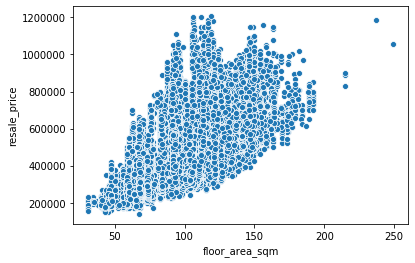

In [8]:
# area vs price
sns.scatterplot(data=df, x='floor_area_sqm', y='resale_price')
#bigger units are more expensive, strong predictor

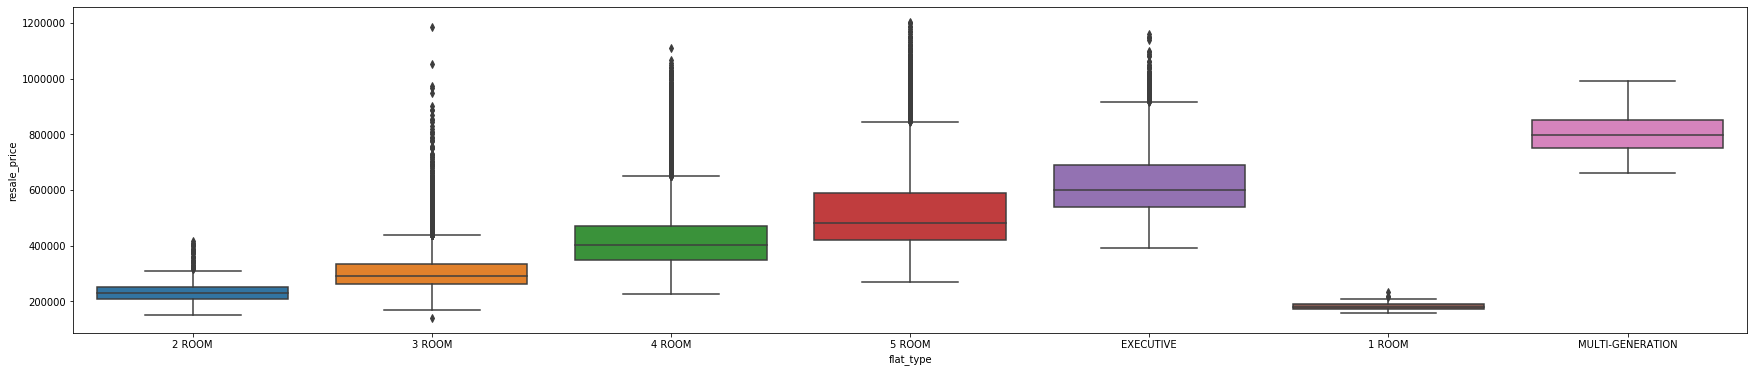

In [9]:
# flat_type vs resale price
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='flat_type', y='resale_price')


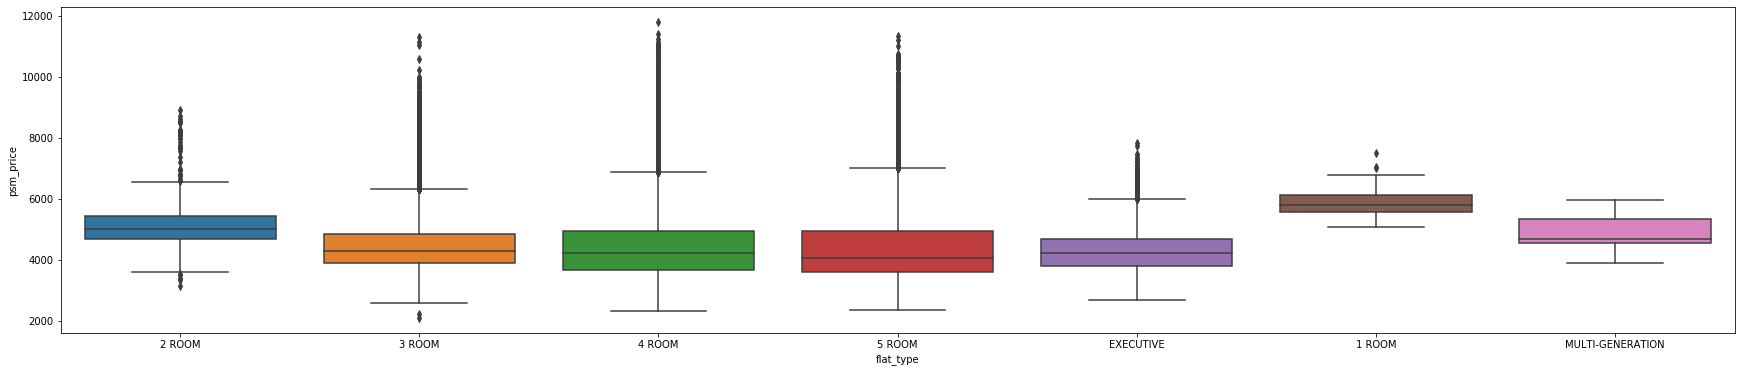

In [113]:
# however the flat type is also highly correlated with size. check the psm_price for each flat type
# flat_type vs psm_price
df.loc[:,'psm_price'] = df.resale_price / df.floor_area_sqm
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='flat_type', y='psm_price')

## after correcting for area, the means of psm_price for most flat types are very similar
## however some flat types still have higher average psm_price 
## - in the particular the small 1/2-room flats, and the multi-gen flats

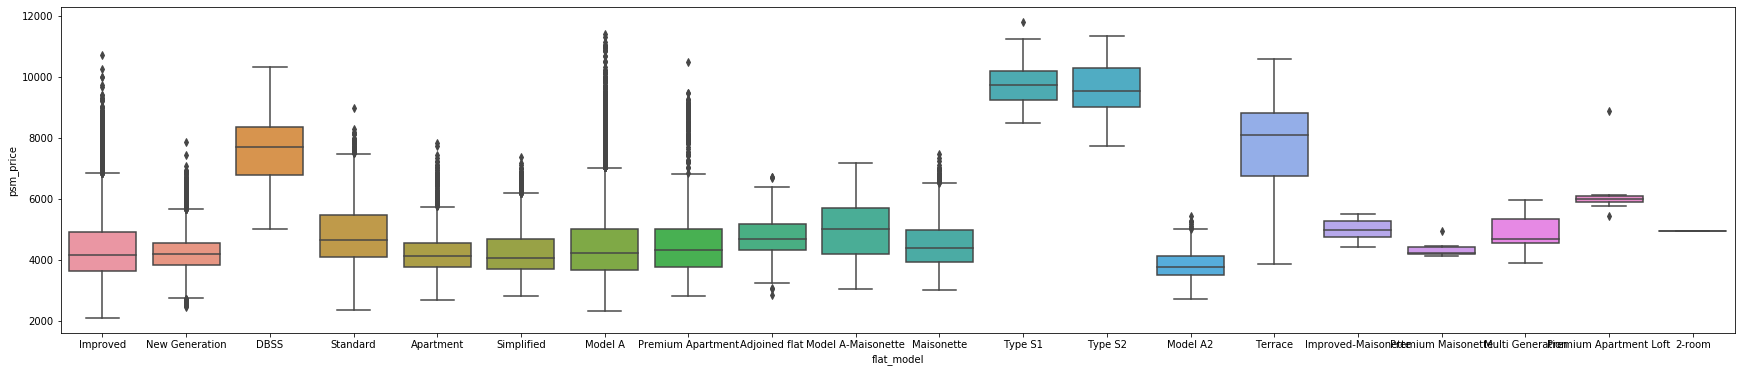

In [11]:
# however the flat type is also highly correlated with size. check the psm_price for each flat type
# flat_type vs psm_price
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='flat_model', y='psm_price')

## some flat models like DBSS, Terrace and Type S1/S2 have far higher mean psm_price.
## could be because they are more exclusive. 

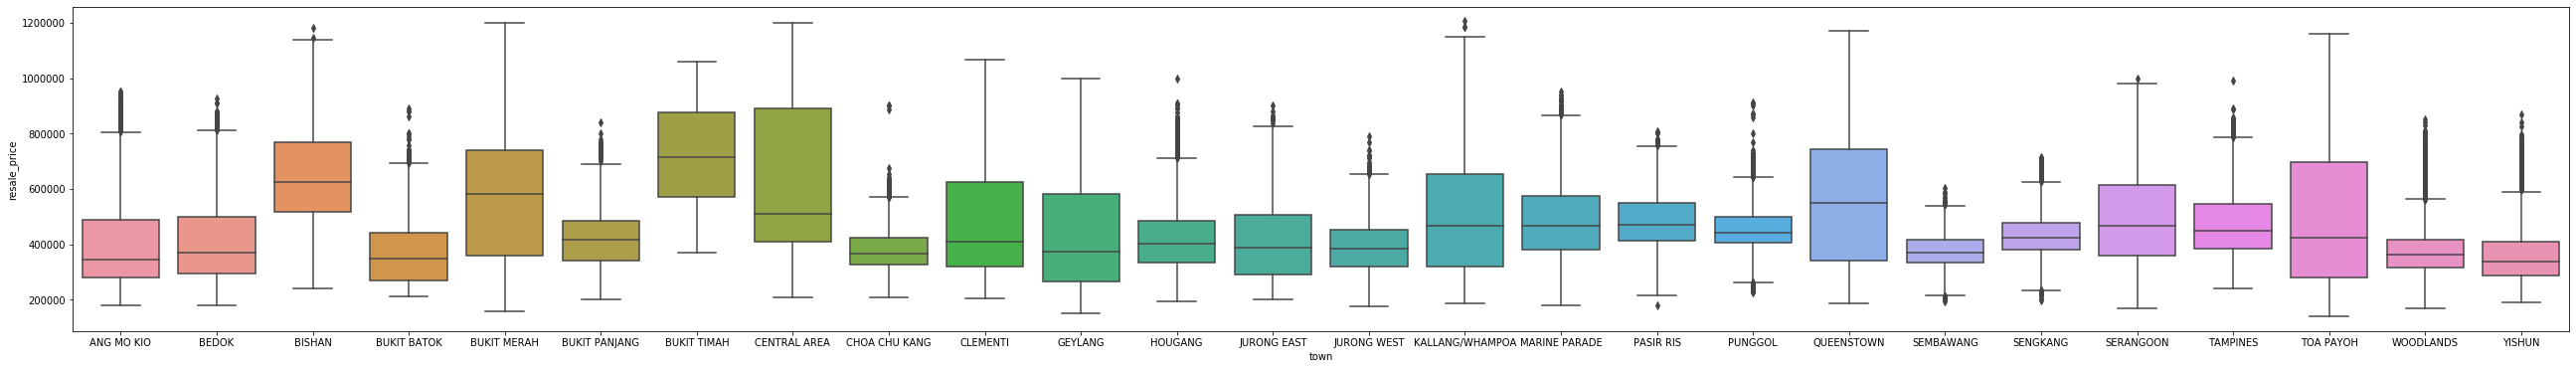

In [12]:
# flat_type vs resale price
plt.figure(figsize=(45, 6))
sns.boxplot(data=df, x='town', y='resale_price')

## there is also significant variation between resale price and town, could be a useful predictor

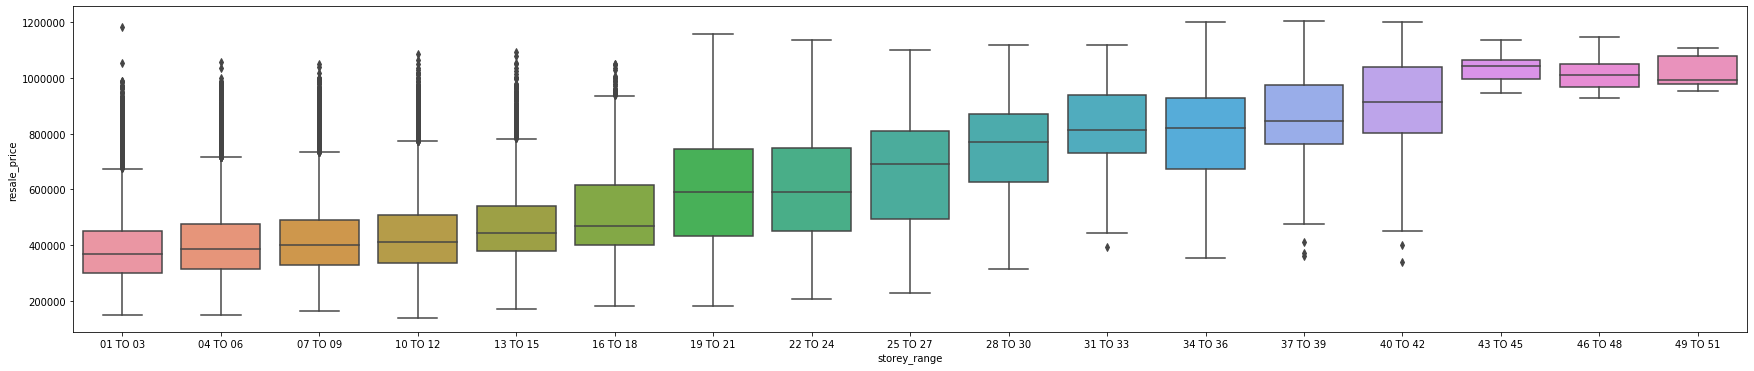

In [13]:
# storey vs resale price
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='storey_range', y='resale_price', order=np.sort(df.storey_range.unique()))

## clear relationship that increasing floor level means increasing price

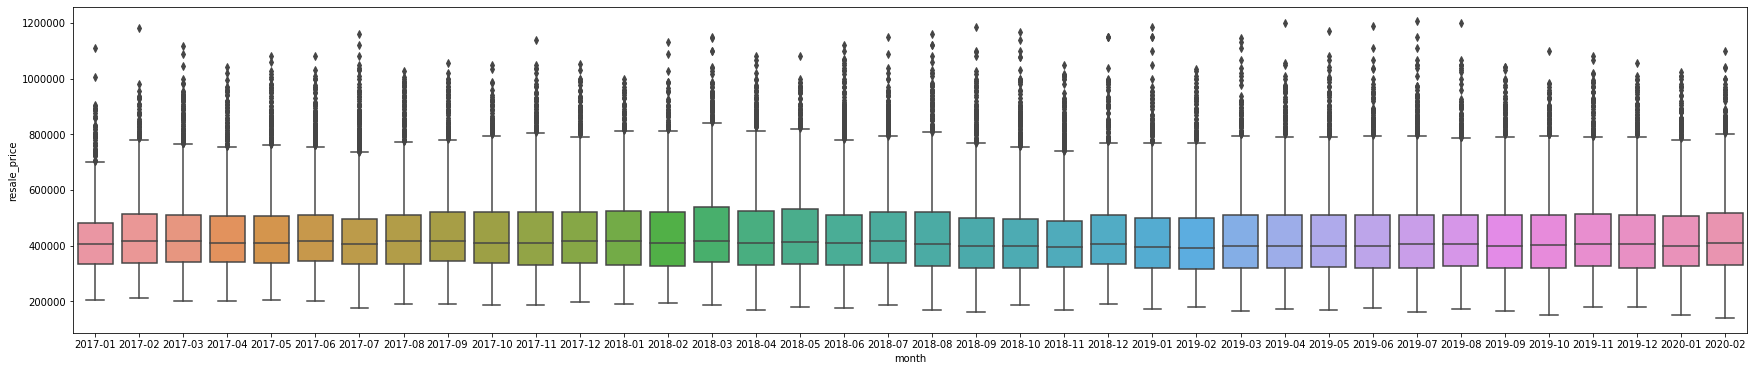

In [14]:
# what about month of sale?
plt.figure(figsize=(30, 6))
sns.boxplot(data=df, x='month', y='resale_price', order=np.sort(df.month.unique()))

# no clear trend, but check if there is any seasonality within the year

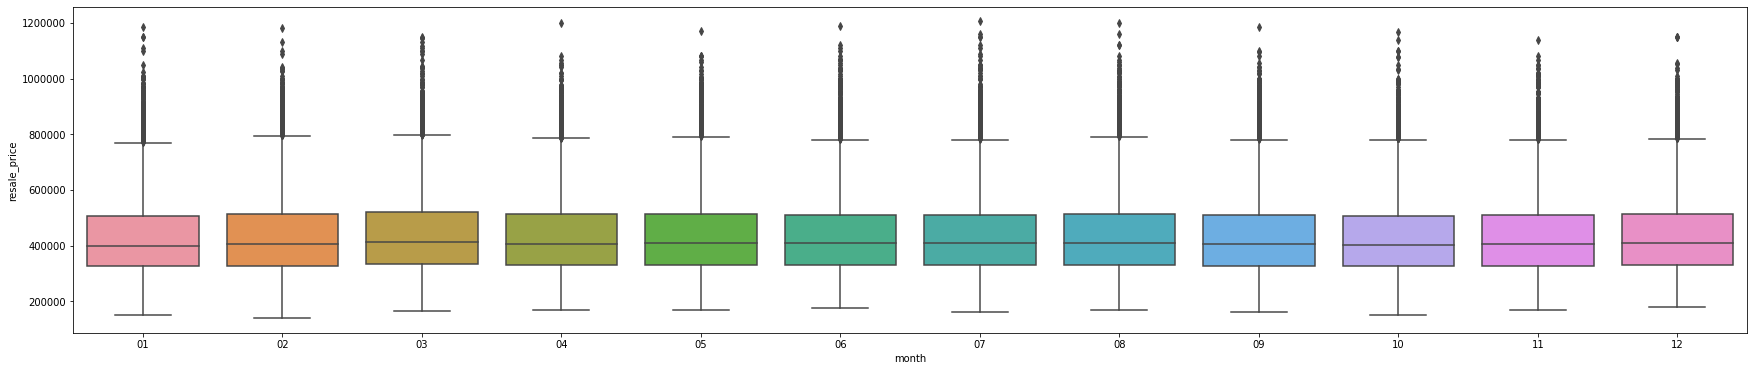

In [15]:
# check if there is any seasonality by month, across the months
plt.figure(figsize=(30, 6))
sns.boxplot(x=df.month.apply(lambda x: x[-2:]), y=df.resale_price)

# no visible trend

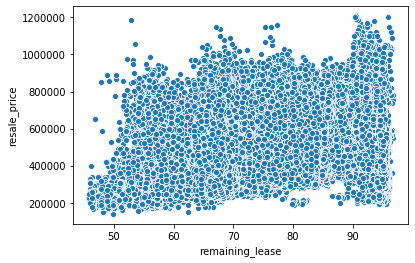

In [16]:
# remaining lease vs resale price
sns.scatterplot(data=df, x='remaining_lease', y='resale_price')

### trend is not so clear, but the higher remaining_lease seems like it tends to have higher resale price.
### can confirm relationship via residual plots after getting an initial model

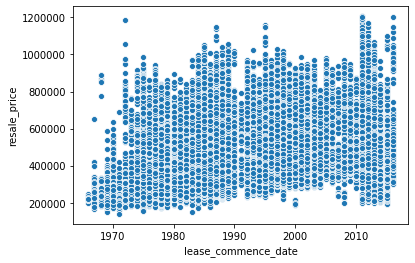

In [17]:
# lease commence date vs resale price
sns.scatterplot(data=df, x='lease_commence_date', y='resale_price')

### similar relationship to remaining_lease as all hdbs flats are sold with 99-year lease
### can probably omit in favour of remaining_lease as remaining_lease as slightly better granularity (months info included)

In [18]:
### baseline prediction of regression model
### using mean price by property type
## the baseline RMSE is calculated from the property price compared to the mean price of its property type 
## calculation is equivalent to std dev with ddof=0
print("baseline prediction:",df['resale_price'].mean())
print("baseline RMSE:",df['resale_price'].std(ddof=0))

baseline prediction: 438863.5022894324
baseline RMSE: 153437.8737270134


## Feature Engineering

In [19]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'psm_price'],
      dtype='object')

In [20]:
### From EDA, can consider predicting two variables: either the resale_price, or psm_price which normalises for area.
## possible dependent variables:
## A. resale_price
## B. psm_price

# possible predictor variables:
# 1. Area
# 2. Town
# 3. Storey
# 4. flat_model
# 5. flat_type (possibly)
# 6. remaining lease / lease commence date

### There are also some other variables that should be important to predicting the resale price:
# 1. distance to MRT or LRT
# 2. distance of nearest MRT/LRT station to the central area
# 3. distance to shopping mall
# 4. distance to supermarket

### Distance to MRT / LRT stations + Travel Time of Nearest Station to CBD

In [21]:
### to get the distance to MRT, we need the coordinates of the hdb block.
### to do this, pass the address into a geocoding API
### re-use the function from another project that uses onemap API - if fail, try Nominatim - if fail, try google maps
## OneMap is accurate but from experience requires an accurate address, and doesn't contain under-construction properties
## google maps has lowest failure rate but is paid API.
## Nominatim is in between OneMap/Google maps in terms of accuracy, but is free API.
# Since the HDB resale data is so clean, I expect all addresses to work with OneMap API

In [88]:
### first, get the full address of the block by combining block and street name 
df.loc[:,'full_address'] = df.block + " " + df.street_name

In [23]:
#### Function to get address, lat, lon from geocoder APIs

### This code uses Nominatim (openstreetmap) API and geopy package
### However, Nominatim is slow and also doesn't contain many Singapore addresses. Use SLA's onemap instead.
def return_lat_lon_nominatim(address):
    try: 
        address, (latitude, longitude)  = geolocator.geocode(address,country_codes='SG')
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan

### this function uses onemap api
import requests
import time

def return_lat_lon_openmap(address,returnCoords='Y',getAddrDetails='Y',PageNumber='1'):
    #time.sleep(60/250) #onemap api is max 250 requests per minute
    try:
        request = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={address}&returnGeom={returnCoords}&getAddrDetails={getAddrDetails}&pageNum={PageNumber}')
        latitude = request.json()['results'][0]['LATITUDE']
        longitude = request.json()['results'][0]['LONGITUDE']
        address = request.json()['results'][0]['ADDRESS']
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan

### this function uses Google maps API. But try this the last because it's a paid API
def return_lat_lon_google(address):
    try: 
        address, (latitude, longitude)  = geolocator_google.geocode(query=address,region='sg')
        return address, latitude, longitude
    except:
        print('failed on ',address)
        return np.nan, np.nan, np.nan


#this is the combined function that uses openmap first, then nominatim, then google
def return_lat_lon(address,returnCoords='Y',getAddrDetails='Y',PageNumber='1'):
    #time.sleep(60/250) #onemap api is max 250 requests per minute
    try:
        request = requests.get(f'https://developers.onemap.sg/commonapi/search?searchVal={address}&returnGeom={returnCoords}&getAddrDetails={getAddrDetails}&pageNum={PageNumber}')
        latitude = request.json()['results'][0]['LATITUDE']
        longitude = request.json()['results'][0]['LONGITUDE']
        address = request.json()['results'][0]['ADDRESS']
        return address, latitude, longitude
    except:
        print('openmap failed on',address,'trying nominatim')
        try:
            address, (latitude, longitude)  = geolocator.geocode(address,country_codes='SG')
            return address, latitude, longitude
        except:    
            print('nominatim failed on',address,'trying googlemaps')
            try:
                address, (latitude, longitude)  = geolocator_google.geocode(query=address,region='sg')
                return address, latitude, longitude
            except:
                print('google maps failed on',address)
                return np.nan, np.nan, np.nan


In [30]:
print(df.shape)
print(len(df.full_address.value_counts()))

# there are 68161 rows in the data, but only 8693 unique addresses.
# since each unique address would have same coordinates, 
# extract the unique addresses and only pass these into the geocoder API
address_df = df.loc[:,['full_address']].drop_duplicates()

(68161, 13)
8693


In [32]:
# pass addresses into geocoder api
address_df.loc[:,'corrected_address'],address_df.loc[:,'lat'],address_df.loc[:,'lng'] = zip(*address_df.full_address.apply(return_lat_lon))

openmap failed on 3 ST. GEORGE'S RD trying nominatim
openmap failed on 21 ST. GEORGE'S RD trying nominatim
openmap failed on 11 ST. GEORGE'S RD trying nominatim
openmap failed on 8 ST. GEORGE'S LANE trying nominatim
openmap failed on 18 ST. GEORGE'S RD trying nominatim
openmap failed on 15 ST. GEORGE'S RD trying nominatim
openmap failed on 9 ST. GEORGE'S RD trying nominatim
openmap failed on 4B ST. GEORGE'S LANE trying nominatim
openmap failed on 7 ST. GEORGE'S LANE trying nominatim
openmap failed on 5 ST. GEORGE'S LANE trying nominatim
openmap failed on 22 ST. GEORGE'S RD trying nominatim
openmap failed on 20 ST. GEORGE'S RD trying nominatim
openmap failed on 13 ST. GEORGE'S RD trying nominatim
openmap failed on 6 ST. GEORGE'S LANE trying nominatim
openmap failed on 2 ST. GEORGE'S RD trying nominatim
openmap failed on 14 ST. GEORGE'S RD trying nominatim
openmap failed on 23 ST. GEORGE'S RD trying nominatim
openmap failed on 16 ST. GEORGE'S RD trying nominatim
openmap failed on 1 ST. G

In [57]:
### cache results to avoid querying again
#address_df.to_csv('cached_hdb_addresses.csv', index=False)

### use this if already cached
address_df = pd.read_csv('cached_hdb_addresses.csv')

In [36]:
### find mrt coordinates, credits to https://www.kaggle.com/yxlee245/distance-from-hdb-block-address-to-nearest-station
mrt_lrt_df_without_tel = pd.read_csv('mrt_lrt_data.csv')

In [72]:
### Find travel time of each MRT station to the CBD - defined as Raffles Place
### inspired from Mengyong et al, source here https://towardsdatascience.com/data-driven-approach-to-understanding-hdb-resale-prices-in-singapore-31c3beecfd97
## can't seem to find a database of travel time from MRT to CBD area.
## make use of Google's distance matrix API which can calculate travel time

# first, get a place name that can be parsed by google's API 
mrt_lrt_df_without_tel.loc[:,'name_with_type'] = mrt_lrt_df_without_tel.station_name + " " + mrt_lrt_df_without_tel.type + " Station"

In [74]:
### this function returns the travel time in seconds and travel distance in meters to Raffles Place MRT
import requests

def return_traveltime(origins,destinations='Raffles Place MRT'):
    #time.sleep(60/250) #onemap api is max 250 requests per minute
    try:
        url = f'https://maps.googleapis.com/maps/api/distancematrix/json?units=metric&mode=transit&origins={origins}&destinations={destinations}&region=sg&key={config.gmaps_api_key}'
        url = url.replace(' ','%20')
        request = requests.get(url)
        time = request.json()['rows'][0]['elements'][0]['duration']['value']
        dist = request.json()['rows'][0]['elements'][0]['distance']['value']
        return time, dist
    except:
        print('failed on ',origins)
        return np.nan, np.nan

In [44]:
# pass mrt into google distance matrix api
mrt_lrt_df_without_tel.loc[:,'travel_time'],mrt_lrt_df_without_tel.loc[:,'travel_distance'] = zip(*mrt_lrt_df_without_tel.name_with_type.apply(return_traveltime))

In [70]:
### reuse function from another project to find distance to closest mrt/lrt and also return the station name and type
# function to find distance between 2 coordinates 
def find_dist(lat1, lon1, lat2, lon2):
    add1 = (lat1,lon1)
    add2 = (lat2,lon2)
    return distance.distance(add1, add2).km

# function that takes in place coordinates and returns the distance to nearest mrt as well as the nearest mrt station
def find_closest_mrt(property_lat, property_lon):
    temp_mrt_lrt_df = mrt_lrt_df[['station_name','type','lat','lng']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_mrt_lrt_df.loc[:,'distance'] = temp_mrt_lrt_df.apply(lambda x: find_dist(property_lat, property_lon, x['lat'], x['lng']), axis = 1)
    min_idx = temp_mrt_lrt_df['distance'].idxmin()
    return temp_mrt_lrt_df.loc[min_idx][['distance','station_name','type']].values

# function for excluding TEL line
def find_closest_mrt_without_tel(property_lat, property_lon):
    temp_mrt_lrt_df = mrt_lrt_df_without_tel[['station_name','type','lat','lng']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_mrt_lrt_df.loc[:,'distance'] = temp_mrt_lrt_df.apply(lambda x: find_dist(property_lat, property_lon, x['lat'], x['lng']), axis = 1)
    min_idx = temp_mrt_lrt_df['distance'].idxmin()
    return temp_mrt_lrt_df.loc[min_idx][['distance','station_name','type']].values


In [71]:
# do calculation to find distance to stations
address_df.loc[:,'distance_to_station'],address_df.loc[:,'nearest_station'],address_df.loc[:,'nearest_station_type'] = zip(*address_df.apply(lambda x: find_closest_mrt_without_tel(x['lat'],x['lng']), axis=1))

In [76]:
mrt_lrt_df_without_tel

,station_name,type,lat,lng,name_with_type,travel_time,travel_distance
0,Jurong East,MRT,1.333207,103.742308,Jurong East MRT Station,1639,15424
1,Bukit Batok,MRT,1.349069,103.749596,Bukit Batok MRT Station,2126,17515
2,Bukit Gombak,MRT,1.359043,103.751863,Bukit Gombak MRT Station,2190,18618
3,Choa Chu Kang,MRT,1.385417,103.744316,Choa Chu Kang MRT Station,2435,21928
4,Yew Tee,MRT,1.397383,103.747523,Yew Tee MRT Station,2604,23394
...,...,...,...,...,...,...,...
152,Punggol Point,LRT,1.416932,103.906680,Punggol Point LRT Station,3330,17901
153,Samudera,LRT,1.415955,103.902185,Samudera LRT Station,3390,18698
154,Nibong,LRT,1.411865,103.900321,Nibong LRT Station,3330,18189
155,Sumang,LRT,1.408501,103.898605,Sumang LRT Station,3271,17770


In [78]:
address_df = address_df.merge(mrt_lrt_df_without_tel[['station_name','travel_time','travel_distance']],\
                             left_on='nearest_station', right_on='station_name', how='left')

In [89]:
# merge back to df
df = df.merge(address_df, on='full_address',how='left')

In [37]:
# ### functions to use in case we want to consider upcoming TEL stations


# #find upcoming TEL stations coordinates which are not in the above list
# tel_mrt_df = pd.read_csv('tel_mrt_names.csv')

# # find upcoming mrt coordinates using geocoder
# tel_mrt_df.mrt_station_name = tel_mrt_df.mrt_station_name.apply(lambda x: x + " MRT Station")
# tel_mrt_df['address'],tel_mrt_df['lat'],tel_mrt_df['lng'] = zip(*tel_mrt_df.mrt_station_name.apply(return_lat_lon))

# tel_mrt_df = tel_mrt_df.rename(columns = {'mrt_station_name':'station_name'})
# tel_mrt_df.loc[:,'type'] = 'MRT'
# mrt_lrt_df = mrt_lrt_df_without_tel.append(tel_mrt_df, sort=False)
# mrt_lrt_df.to_csv('mrt_lrt_names_combined.csv') # cache for future use to avoid geocoding again

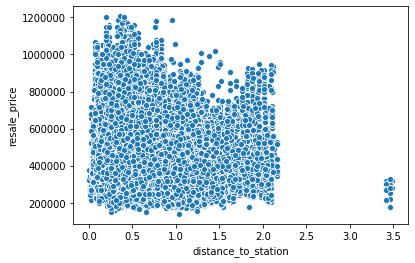

In [90]:
sns.scatterplot(data=df,x='distance_to_station',y='resale_price')

## relationship is not so clear from the scatterplot
## can see that the most expensive flats are quite near (within ~0.8km of station which is roughly 10 min walk away)
## perhaps it only matters whether the station is within walking distance or not
## check relationship later using residual plots

### Distance to Malls

In [4]:
# ### get list of malls https://en.wikipedia.org/wiki/List_of_shopping_malls_in_Singapore
# mall_list = pd.read_csv('malls.csv')

In [6]:
# # get coordinates of malls using function above
# mall_list.loc[:,'full_address'], mall_list.loc[:,'latitude'], mall_list.loc[:,'longitude'] = zip(*mall_list['mall_name'].apply(return_lat_lon))

openmap failed on Clarke Quay Central trying nominatim
openmap failed on City Gate Mall trying nominatim
openmap failed on Holland Village Shopping Mall trying nominatim
nominatim failed on Holland Village Shopping Mall trying googlemaps
openmap failed on Mustafa Shopping Centre trying nominatim
nominatim failed on Mustafa Shopping Centre trying googlemaps
openmap failed on PoMo trying nominatim
openmap failed on Shaw House and Centre trying nominatim
openmap failed on United Square, The Kids Learning Mall trying nominatim
nominatim failed on United Square, The Kids Learning Mall trying googlemaps
openmap failed on myVillage @ Serangoon trying nominatim
openmap failed on Yew Tee Shopping Centre trying nominatim
nominatim failed on Yew Tee Shopping Centre trying googlemaps
openmap failed on KKH The Retail Mall trying nominatim
nominatim failed on KKH The Retail Mall trying googlemaps
openmap failed on Westgate Mall trying nominatim
openmap failed on OD Mall trying nominatim


In [91]:
##can see that some entries are badly named so onemap doesn't have the entries, but nominatim and google maps can pick up the slack.
#mall_list.to_csv('malls_with_coordinates.csv',index=False) #cache results

##retrieve cached results
mall_list = pd.read_csv('malls_with_coordinates.csv')

In [92]:
### define function that takes in place coordinates and returns the nearest shopping mall and distance
def find_closest_mall(property_lat, property_lon):
    temp_mall_df = mall_list[['mall_name','latitude','longitude']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_mall_df.loc[:,'distance'] = temp_mall_df.apply(lambda x: find_dist(property_lat, property_lon, x['latitude'], x['longitude']), axis = 1)
    min_idx = temp_mall_df['distance'].idxmin()
    return temp_mall_df.loc[min_idx][['distance','mall_name']].values

In [93]:
# do calculation to find distance to malls
address_df.loc[:,'distance_to_mall'],address_df.loc[:,'nearest_mall'] = zip(*address_df.apply(lambda x: find_closest_mall(x['lat'],x['lng']), axis=1))

In [94]:
df = df.merge(address_df[['full_address','distance_to_mall','nearest_mall']], on='full_address', how='left')

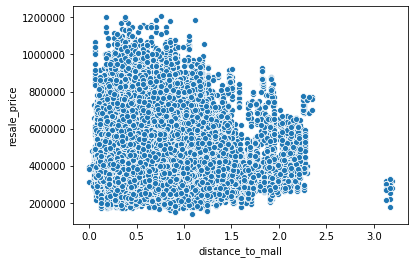

In [95]:
sns.scatterplot(data=df,x='distance_to_mall',y='resale_price')

## the most expensive flats are typically closer to the malls

### Distance to supermarket

In [96]:
### supermarket coordinates are taken from data.gov.sg
# https://data.gov.sg/dataset/supermarkets
kml_file = 'supermarkets-kml.kml'

In [97]:
## data is provided in a kml file. use lxml to parse

from lxml import etree

ns = {"kml": "http://www.opengis.net/kml/2.2"}

tree = etree.parse(kml_file)

supermarket_data = []

for supermarket in tree.findall("//kml:Placemark", namespaces=ns):
    name = supermarket.find(".//kml:SimpleData[@name='LIC_NAME']", namespaces=ns).text
    lng = supermarket.find(".//kml:coordinates",namespaces=ns).text.split(',')[0]
    lat = supermarket.find(".//kml:coordinates",namespaces=ns).text.split(',')[1]
    row = [name,lat,lng]
    supermarket_data.append(row)

column_names = ['supermarket','lat','lng']
supermarket_df = pd.DataFrame(columns = column_names,data=supermarket_data)

In [98]:
### define function that takes in place coordinates and returns the nearest shopping mall and distance
def find_closest_supermarket(property_lat, property_lon):
    temp_supermarket_df = supermarket_df[['supermarket','lat','lng']].copy().reset_index(drop=True) #create a temp copy of mrt coordinates df
    temp_supermarket_df.loc[:,'distance'] = temp_supermarket_df.apply(lambda x: find_dist(property_lat, property_lon, x['lat'], x['lng']), axis = 1)
    min_idx = temp_supermarket_df['distance'].idxmin()
    return temp_supermarket_df.loc[min_idx][['distance','supermarket']].values

In [99]:
# do calculation to find distance to malls
address_df.loc[:,'distance_to_supermarket'],address_df.loc[:,'nearest_supermarket'] = zip(*address_df.apply(lambda x: find_closest_supermarket(x['lat'],x['lng']), axis=1))

In [100]:
df = df.merge(address_df[['full_address','distance_to_supermarket','nearest_supermarket']], on='full_address', how='left')

In [114]:
###cache results to avoid processing in the future
#df.to_csv('hdb_resale_data_with_distances.csv', index=False)

### read cached results
df = pd.read_csv('hdb_resale_data_with_distances.csv')

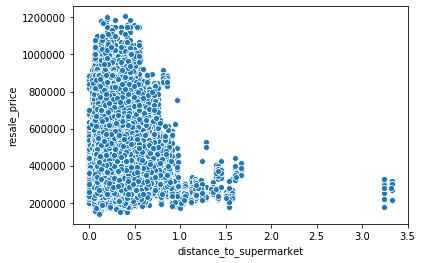

In [102]:
sns.scatterplot(data=df,x='distance_to_supermarket',y='resale_price')

## the most expensive flats are typically closer to the supermarkets

### Dummy Variables for Town, Storey, Flat Model, Flat Type

In [106]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'full_address', 'corrected_address',
       'lat', 'lng', 'distance_to_station', 'nearest_station',
       'nearest_station_type', 'station_name', 'travel_time',
       'travel_distance', 'distance_to_mall', 'nearest_mall',
       'distance_to_supermarket', 'nearest_supermarket'],
      dtype='object')

In [107]:
town_dummies = pd.get_dummies(df['town'], prefix = 'town')
storey_dummies = pd.get_dummies(df['storey_range'], prefix = 'storey')
flat_model_dummies = pd.get_dummies(df['flat_model'], prefix = 'model')
flat_type_dummies = pd.get_dummies(df['flat_type'], prefix = 'type')

## Model

### Linear Regression

In [109]:
df.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'full_address', 'corrected_address',
       'lat', 'lng', 'distance_to_station', 'nearest_station',
       'nearest_station_type', 'station_name', 'travel_time',
       'travel_distance', 'distance_to_mall', 'nearest_mall',
       'distance_to_supermarket', 'nearest_supermarket'],
      dtype='object')

In [200]:
## define X and Y vars
model_df = pd.concat([df, town_dummies, storey_dummies, flat_model_dummies, flat_type_dummies], axis=1)
model_df = model_df.drop(['town','storey_range','flat_model','flat_type','month', 'block', 'street_name','lease_commence_date',\
                          'full_address','corrected_address','lat','lng','nearest_station','station_name','nearest_station_type',\
                         'nearest_mall', 'nearest_supermarket','travel_distance'],axis=1)

In [227]:
X = model_df.drop(['resale_price','psm_price'],axis=1)
Y = model_df.resale_price

In [228]:
lin_reg = LinearRegression()

In [229]:
lin_reg.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [230]:
Y_pred = lin_reg.predict(X)

In [231]:
from sklearn.metrics import mean_squared_error, r2_score

In [232]:
# The coefficients
print('Coefficients: \n', lin_reg.coef_)
# The mean squared error
print('Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(Y, Y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y, Y_pred))

Coefficients: 
 [ 3.55785971e+03  4.88399664e+03 -6.45782086e+04 -5.00855708e+01
 -1.99171464e+04  2.83819204e+03  7.42926262e+03  4.05048095e+03
  1.11294530e+05 -5.50186596e+04  8.09022897e+04 -8.22954340e+04
  2.14145888e+05  4.49538862e+04 -1.28321882e+05  4.34663197e+04
  2.52249742e+04 -3.24827127e+04 -3.69770513e+04 -9.84043521e+04
  3.27676061e+04  2.26615066e+05 -3.21626144e+04 -7.69201447e+04
  8.57663392e+04 -1.58072741e+05 -1.06048138e+05  4.52874472e+04
 -7.52840622e+02  4.14892782e+04 -8.02136181e+04 -7.57231793e+04
 -1.05697576e+05 -8.86843349e+04 -7.60968856e+04 -6.69629846e+04
 -5.70261972e+04 -4.07756829e+04 -1.23161844e+04 -5.88243427e+03
  9.19892615e+03  2.49812278e+04  2.49643697e+04  3.52717891e+04
  5.94892568e+04  7.43749077e+04  8.00986879e+04  6.55320266e+04
  7.95310883e+04 -9.78756347e+04 -2.03933552e+04 -5.37543842e+04
  3.81429305e+04 -8.87812505e+04  8.34101678e+04 -1.93474462e+04
 -8.87512678e+04  3.29215040e+04 -7.66842236e+04  3.86168426e+04
 -7.49962

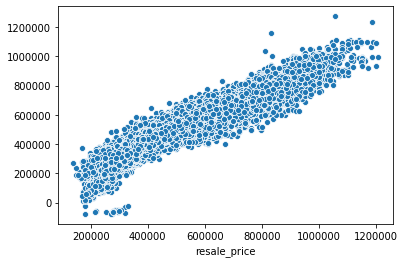

In [233]:
resid = Y-Y_pred
sns.scatterplot(x=Y,y=Y_pred)
# residuals plot shows that model may be 'over-predicting' flats at around $400k range, 
# and 'under-predicting' flats in other range

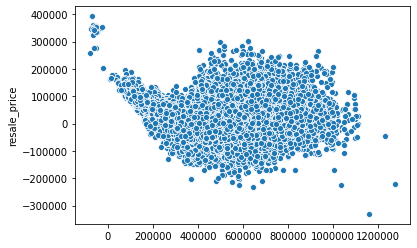

In [241]:
sns.scatterplot(x=Y_pred,y=resid)
# looks like the model fails the homoscedascity assumption
# some flat types are even predicted to be negative which is not possible

In [243]:
df[Y_pred<0] ### changi village is seen to be an outlier. can remove from the model.

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,...,nearest_station_type,station_name,travel_time,travel_distance,distance_to_mall,nearest_mall,distance_to_supermarket,nearest_supermarket,psm_price,storey
666,2017-01,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,04 TO 06,66.0,Improved,1981,63.500000,...,MRT,Changi Airport,3382,19711,3.169403,Jewel Changi Airport,3.244637,RAW MARKET PTE. LTD.,4333.333333,5.0
5124,2017-04,PASIR RIS,3 ROOM,4,CHANGI VILLAGE RD,01 TO 03,66.0,Improved,1980,62.250000,...,MRT,Changi Airport,3382,19711,3.190118,Jewel Changi Airport,3.318017,RAW MARKET PTE. LTD.,4848.484848,2.0
8846,2017-06,PASIR RIS,3 ROOM,1,CHANGI VILLAGE RD,01 TO 03,77.0,Improved,1980,62.083333,...,MRT,Changi Airport,3382,19711,3.126753,Jewel Changi Airport,3.325373,RAW MARKET PTE. LTD.,4155.844156,2.0
10548,2017-07,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,01 TO 03,66.0,Improved,1981,63.000000,...,MRT,Changi Airport,3382,19711,3.169403,Jewel Changi Airport,3.244637,RAW MARKET PTE. LTD.,4469.696970,2.0
12437,2017-08,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,01 TO 03,66.0,Improved,1981,63.000000,...,MRT,Changi Airport,3382,19711,3.169403,Jewel Changi Airport,3.244637,RAW MARKET PTE. LTD.,3863.636364,2.0
14216,2017-09,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,04 TO 06,66.0,Improved,1981,62.833333,...,MRT,Changi Airport,3382,19711,3.169403,Jewel Changi Airport,3.244637,RAW MARKET PTE. LTD.,4621.212121,5.0
20894,2018-01,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,04 TO 06,66.0,Improved,1981,62.500000,...,MRT,Changi Airport,3382,19711,3.169403,Jewel Changi Airport,3.244637,RAW MARKET PTE. LTD.,4469.696970,5.0
22016,2018-02,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,04 TO 06,74.0,Improved,1981,62.416667,...,MRT,Changi Airport,3382,19711,3.169403,Jewel Changi Airport,3.244637,RAW MARKET PTE. LTD.,4459.459459,5.0
31347,2018-07,PASIR RIS,3 ROOM,5,CHANGI VILLAGE RD,04 TO 06,66.0,Improved,1981,62.083333,...,MRT,Changi Airport,3382,19711,3.169403,Jewel Changi Airport,3.244637,RAW MARKET PTE. LTD.,4242.424242,5.0
31348,2018-07,PASIR RIS,3 ROOM,1,CHANGI VILLAGE RD,04 TO 06,66.0,Improved,1980,61.000000,...,MRT,Changi Airport,3382,19711,3.126753,Jewel Changi Airport,3.325373,RAW MARKET PTE. LTD.,4545.454545,5.0


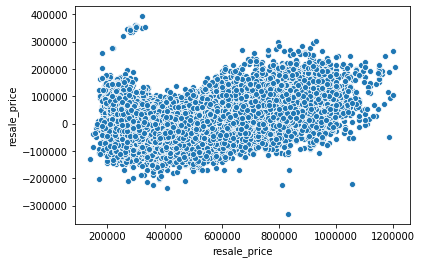

In [235]:
sns.scatterplot(x=Y,y=resid)
# residuals plot shows that model may be 'over-predicting' flats at around $400k range, 
# and 'under-predicting' flats in other range

C:\Users\justin.wong\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


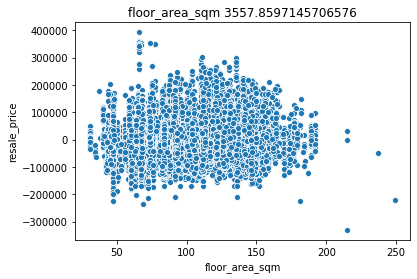

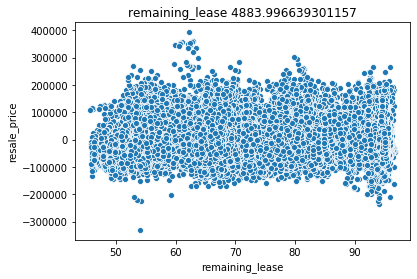

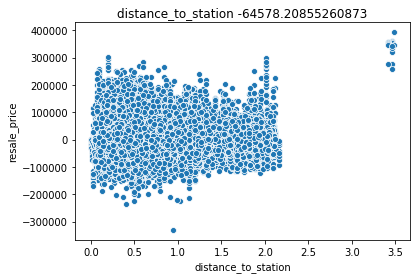

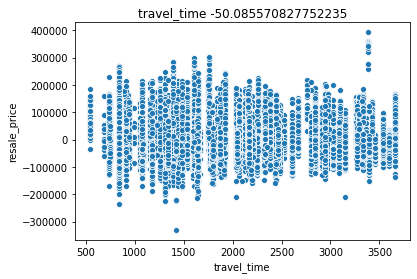

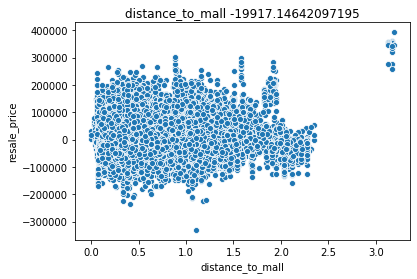

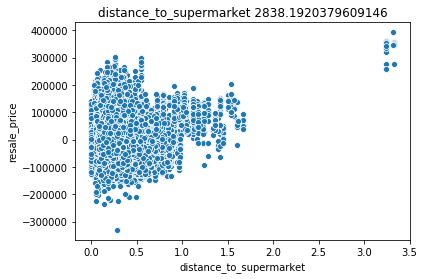

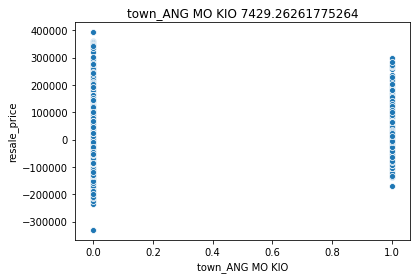

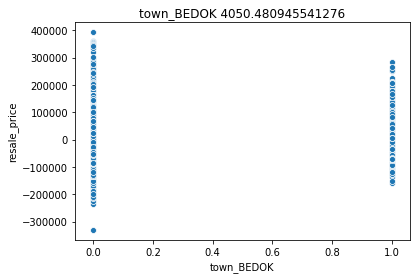

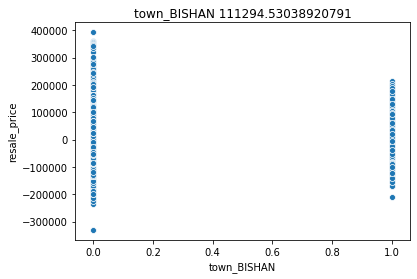

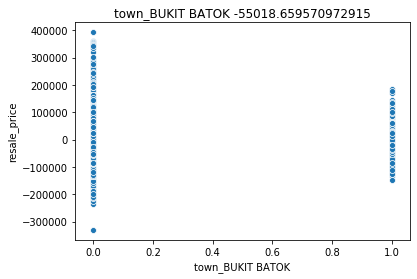

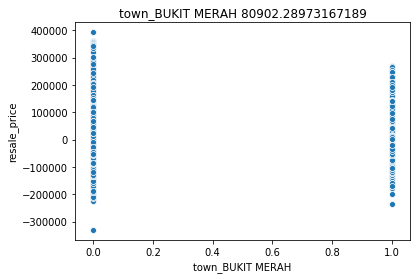

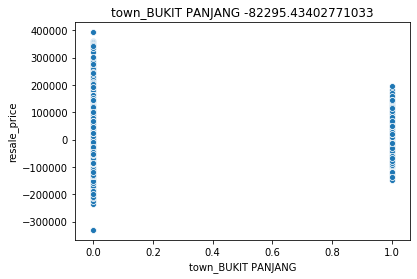

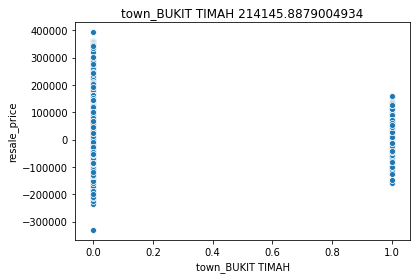

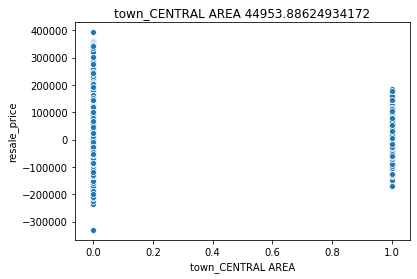

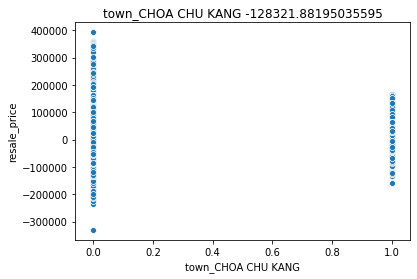

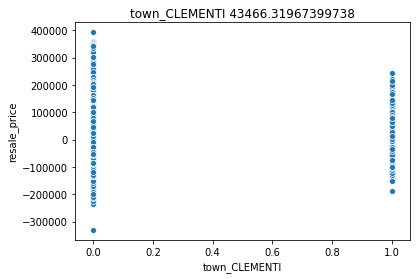

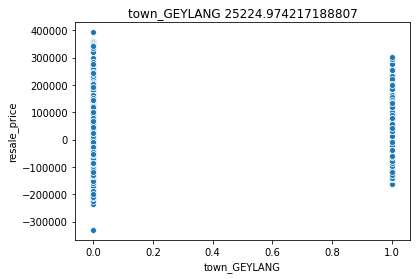

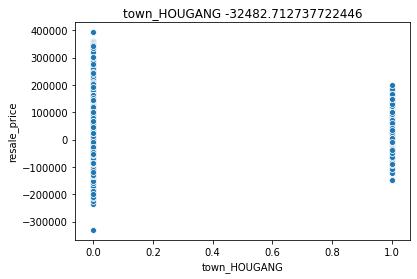

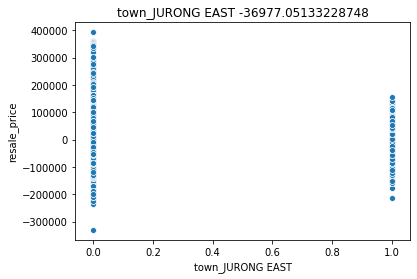

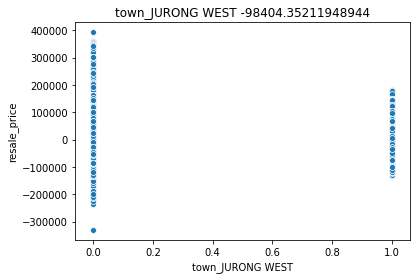

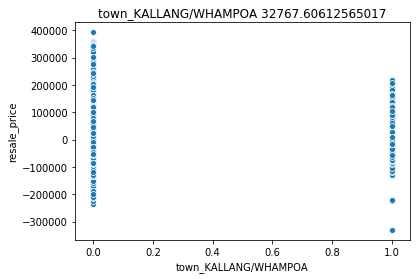

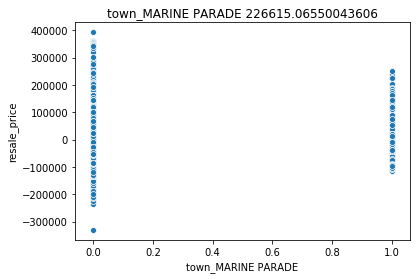

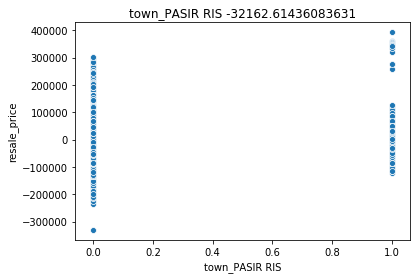

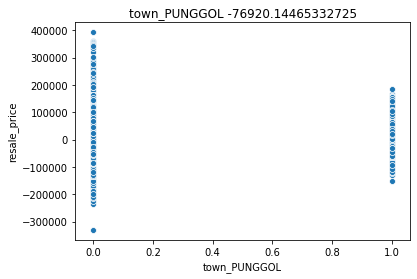

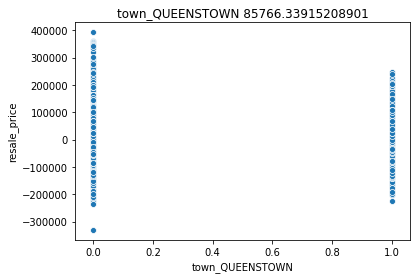

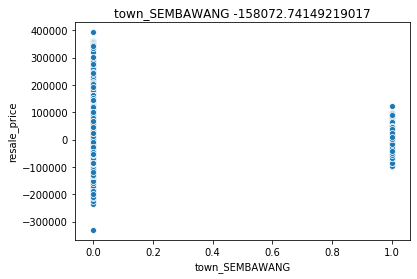

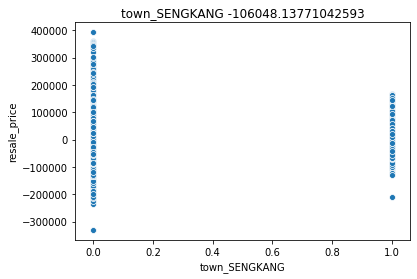

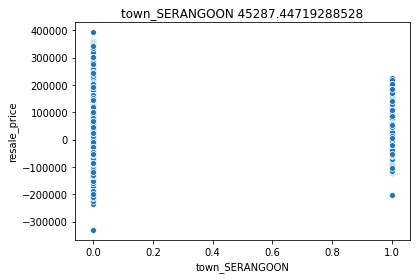

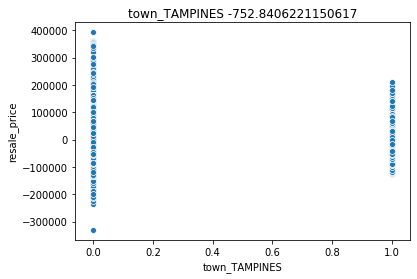

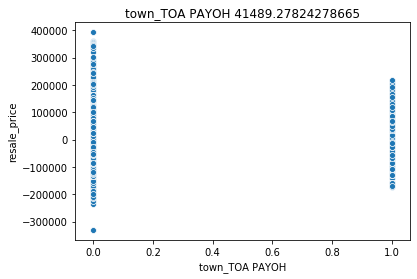

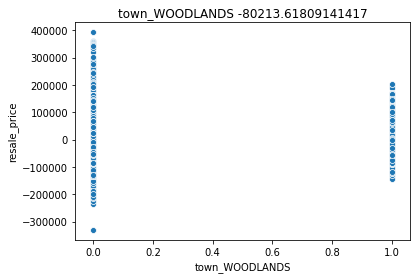

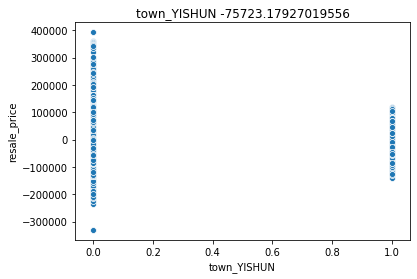

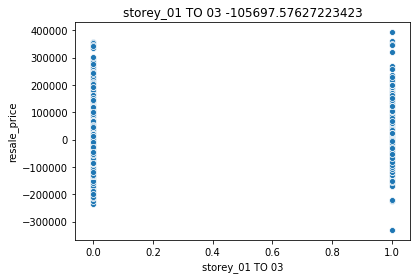

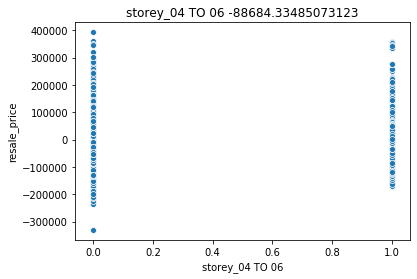

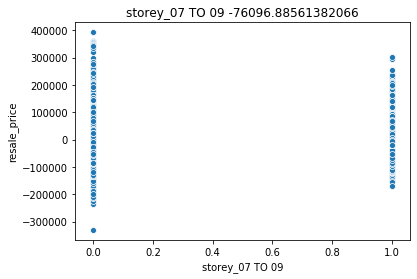

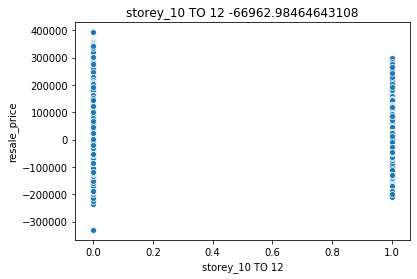

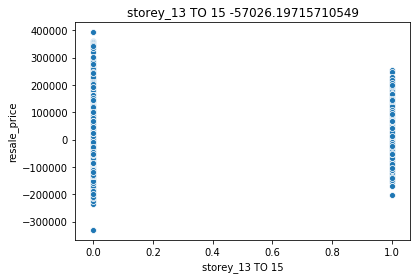

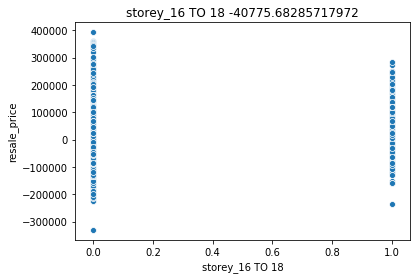

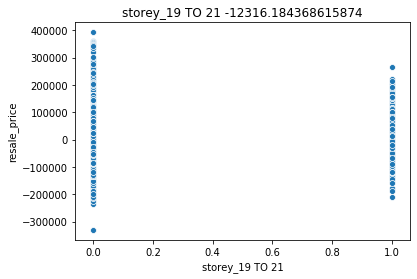

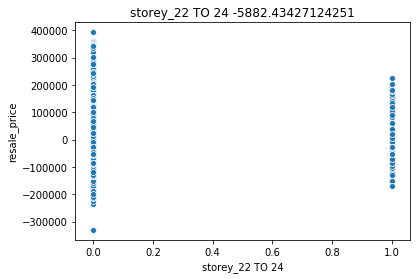

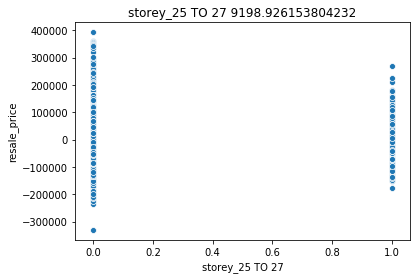

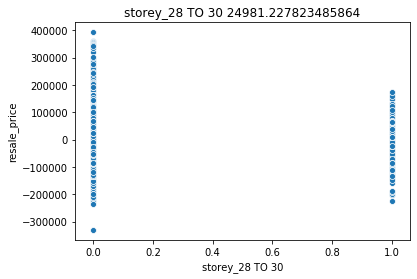

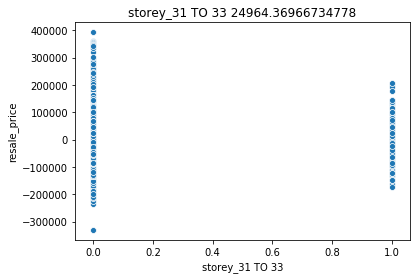

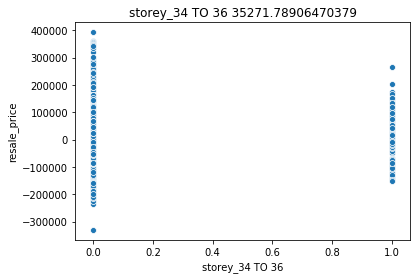

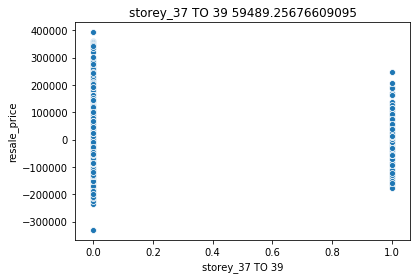

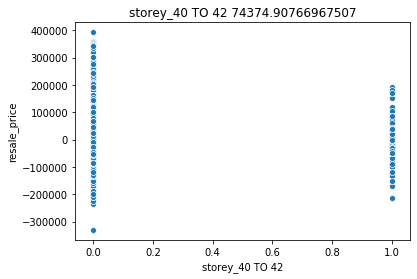

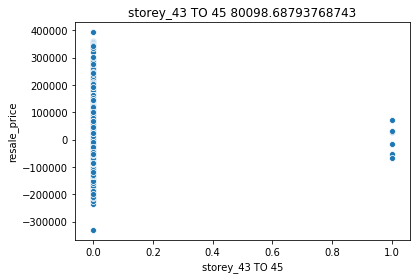

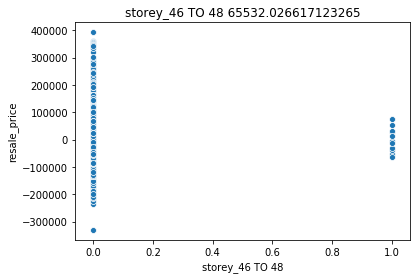

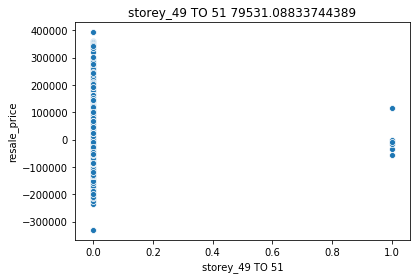

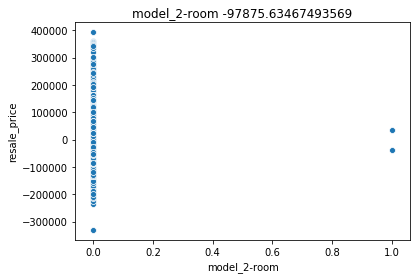

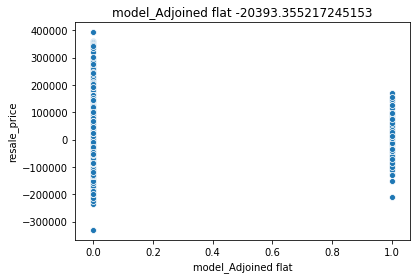

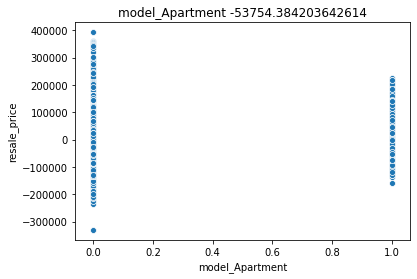

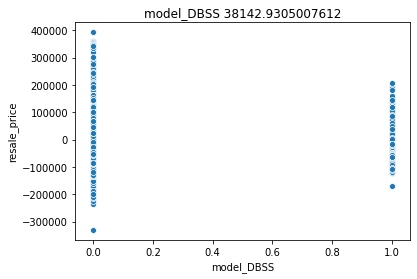

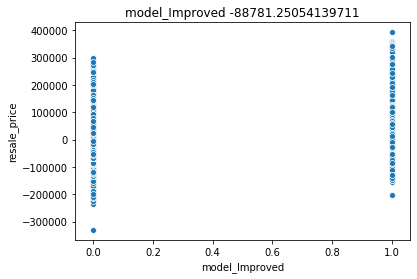

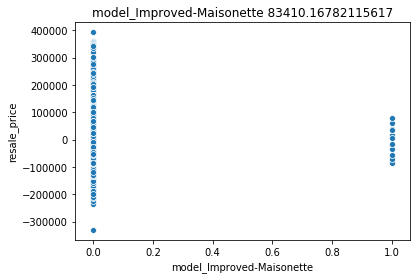

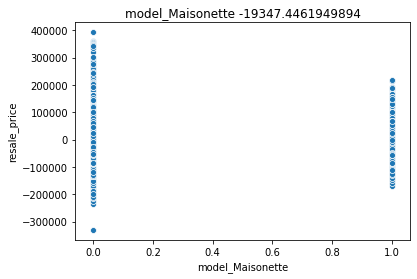

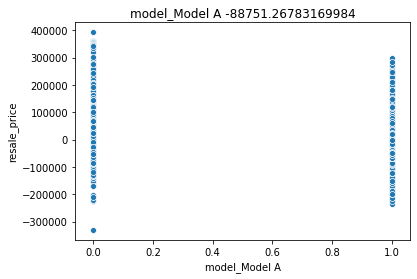

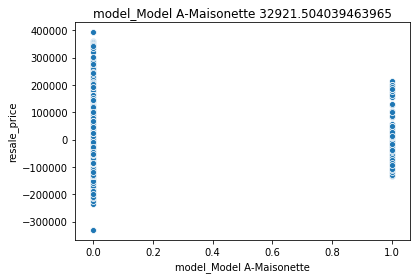

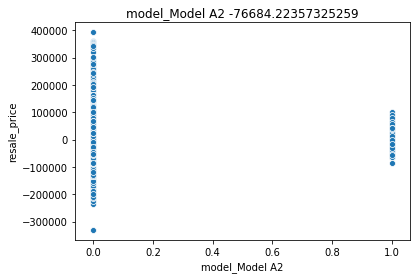

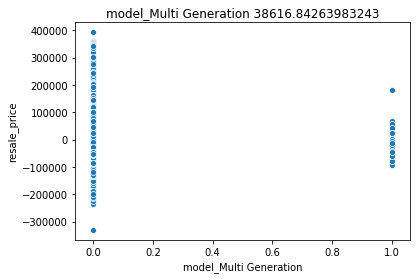

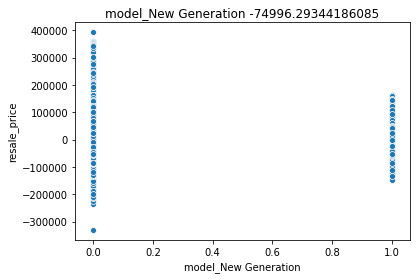

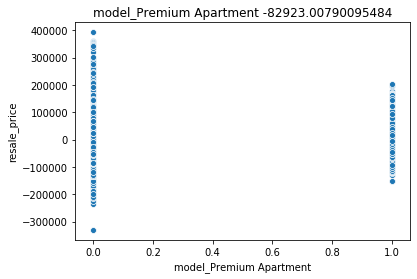

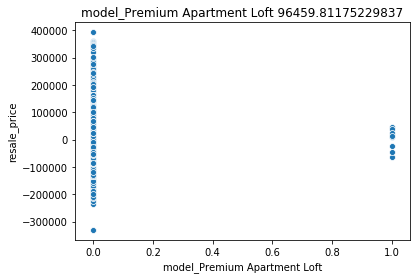

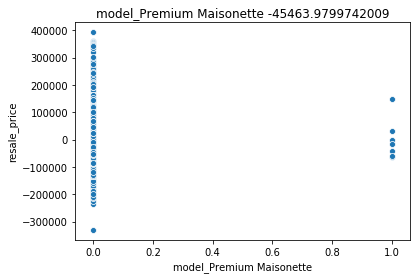

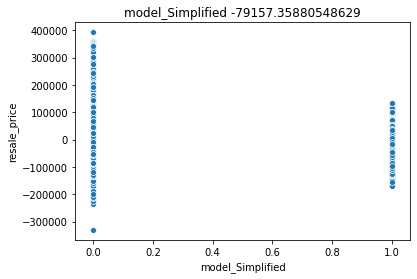

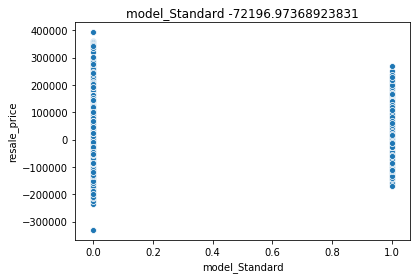

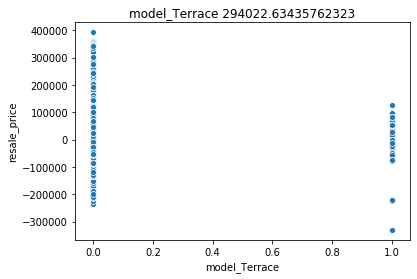

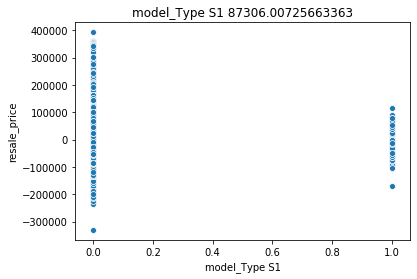

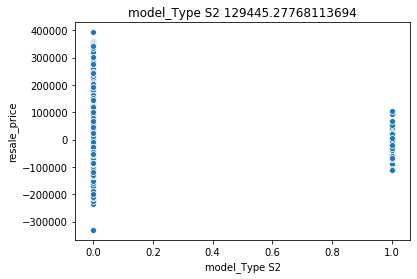

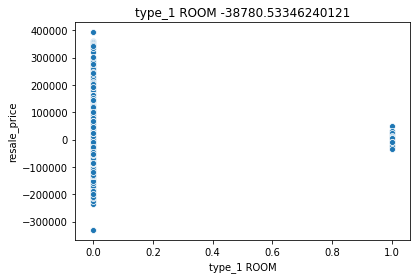

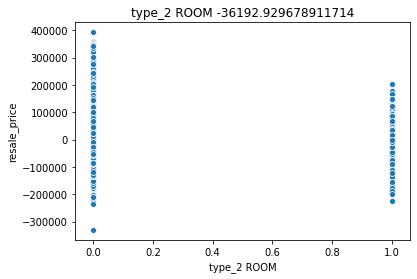

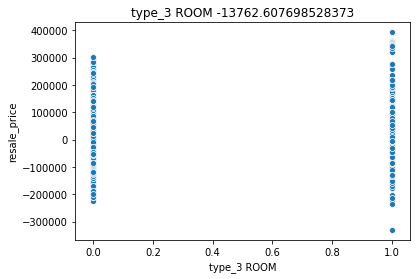

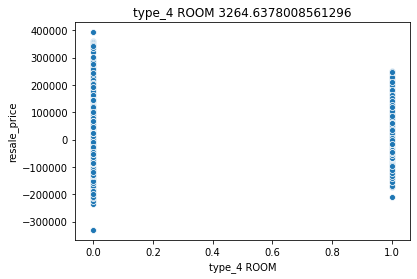

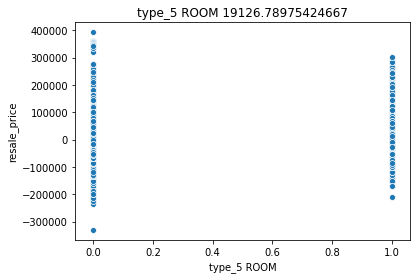

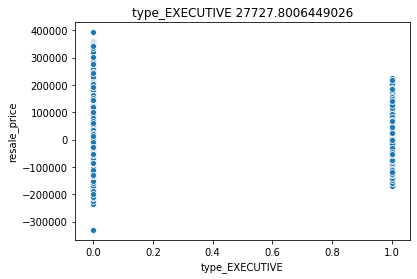

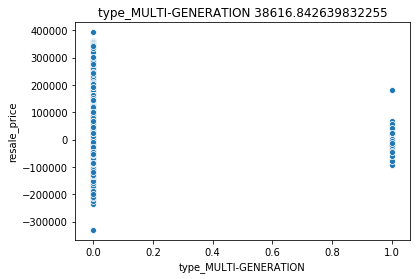

In [236]:
for i, col in enumerate(X.columns):
    plt.figure(i)
    plt.title(col + " " + str(lin_reg.coef_[i]))
    sns.scatterplot(x=col, y=resid,data=model_df)
    #print(col, lin_reg.coef_[i])

In [237]:
for i,d in zip(X.columns,lin_reg.coef_):
    print(i,d)
print('Intercept', lin_reg.intercept_)

floor_area_sqm 3557.8597145706576
remaining_lease 4883.996639301157
distance_to_station -64578.20855260873
travel_time -50.085570827752235
distance_to_mall -19917.14642097195
distance_to_supermarket 2838.1920379609146
town_ANG MO KIO 7429.26261775264
town_BEDOK 4050.480945541276
town_BISHAN 111294.53038920791
town_BUKIT BATOK -55018.659570972915
town_BUKIT MERAH 80902.28973167189
town_BUKIT PANJANG -82295.43402771033
town_BUKIT TIMAH 214145.8879004934
town_CENTRAL AREA 44953.88624934172
town_CHOA CHU KANG -128321.88195035595
town_CLEMENTI 43466.31967399738
town_GEYLANG 25224.974217188807
town_HOUGANG -32482.712737722446
town_JURONG EAST -36977.05133228748
town_JURONG WEST -98404.35211948944
town_KALLANG/WHAMPOA 32767.60612565017
town_MARINE PARADE 226615.06550043606
town_PASIR RIS -32162.61436083631
town_PUNGGOL -76920.14465332725
town_QUEENSTOWN 85766.33915208901
town_SEMBAWANG -158072.74149219017
town_SENGKANG -106048.13771042593
town_SERANGOON 45287.44719288528
town_TAMPINES -752.84

In [100]:
# The coefficients
print('Coefficients: \n', lin_reg.coef_)
# The mean squared error
print('Root mean squared error: %.2f'
      % np.sqrt(mean_squared_error(Y, Y_pred)))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(Y, Y_pred))

Coefficients: 
 [   3512.02132518     289.34194814    4495.46045537  -64225.50932309
  -21339.31018094    3427.51898867   29256.3131368    18009.996014
  135074.77974691  -60454.47140068  127250.71295802 -141330.52388692
  209458.83897228   97269.81669334 -174410.63529033   63728.30314914
   53695.23965817  -50700.3545118   -23097.36788374 -104696.97639942
   69151.10871915  258673.56750792  -57480.74951215 -134310.38554934
  121526.30807733 -178574.18336034 -152579.91061159   49369.54455714
  -22120.79519207   67667.80115207 -119438.79348758  -80937.18325633
 -105776.24939014  -88964.28318264  -76454.11670574  -67001.78965188
  -57029.35296024  -42343.0906943   -12857.71771086   -6555.41853144
   10187.52381482   26760.26925007   24418.5657909    37769.90225835
   58633.03184818   74133.51943335   80000.09657289   65460.90614643
   79618.20371226 -105144.30287131  -22675.24872738  -51925.63997956
   33087.18155517  -90731.47033902   96099.22015321  -15041.92329027
  -90018.01069757   

### Using statsmodels package
SKLearn's linear regression models do not show the p-value of coefficients and other statistical values of the fitted model

Use statsmodel package instead which can show the stats

In [144]:
import statsmodels.api as sm

In [238]:
# remove one category of each one-hot encoded variable. This allows us to check for multicollinearity properly using VIF 
# This means that the 'default unit' would be one of storey 01 to 03, new generation, 4 room, in ang mo kio
X_sm = X.drop(['storey_01 TO 03','model_New Generation','type_4 ROOM','town_ANG MO KIO'],axis=1) 

X_sm = sm.add_constant(X_sm) # to add the intercept for statsmodel

C:\Users\justin.wong\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [239]:
model = sm.OLS(Y,X_sm)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     7979.
Date:                Mon, 20 Apr 2020   Prob (F-statistic):               0.00
Time:                        00:19:39   Log-Likelihood:            -8.3456e+05
No. Observations:               68161   AIC:                         1.669e+06
Df Residuals:                   68089   BIC:                         1.670e+06
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [152]:
### Storey
# when storey increases, the price also increases. 
# however, one outlier from this trend is storey 46 to 48, where the coefficient is lower than storey 43 to 45
# This could be due to influence from other factors which are not captured in this model.
# For instance, flats at the top floor of the block may be priced higher. 
# To factor this into the model, we would require information of the number of storeys of every block, which we currently dont.
# Another factor could be that there may be multicollinearity with another independent variable in the model.
# for instance, I suspect that flats over 45 storeys high are all in Pinnacle @ Duxton, 
# and similarly, flat_model S1 and S2 are only at Pinnacle at Duxton. 
# One way to test this is to convert the storey number into a continuous variable and see how the coefficients changed.
# The storey were initially left as dummy variables in case the relationship of storey vs price was not linear.

In [153]:
### Distance to supermarket
# the coefficient for distance to supermarket doesn't make sense - 
# the model predicts that the farther the flat is from a supermarket, the more expensive the flat is
# there could be strong autocorrelation with another variable, probably distance to mall
# remove this in the next model revision

In [240]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

variables = model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 

C:\Users\justin.wong\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


[599.4750848543281,
 20.473859134744206,
 3.4879130571702417,
 1.917746703828869,
 7.870937358726403,
 1.5668073218629688,
 1.1945523849865456,
 2.248658955078752,
 1.5425090360426224,
 2.100247022401112,
 2.2388526584946975,
 3.8327722036651983,
 1.1071260670154235,
 1.833250502629022,
 3.4786776109809363,
 1.4771614083058409,
 1.751303628581231,
 2.6743601065537033,
 1.550265740671151,
 3.366664348371568,
 1.8902057599285134,
 1.2761947775991969,
 2.3199402684692636,
 5.855299898835313,
 1.879801223745229,
 2.201947300040055,
 6.074567850121926,
 1.594873782048959,
 3.470701645449701,
 1.9602183642355562,
 4.978719229049823,
 3.003660243039501,
 1.7739949651484654,
 1.7444911272554382,
 1.6955293501301454,
 1.4733853069055165,
 1.2608160200531242,
 1.1386101981944179,
 1.1151084155072257,
 1.0789992601875649,
 1.0755056567166603,
 1.0507705913276815,
 1.0474507155834363,
 1.0558509778959952,
 1.0387969204037741,
 1.0393950611375624,
 1.0739465132684967,
 1.044554708588965,
 1.0036235

In [ ]:
### very strong multicollinearity between model_multi generation and type_multi generation, probably because these model and type always occur together
# there is also strong multicollinearity in type_executive
# strong multicollinearity in floor_area - probably correlated with the flat_type or flat_model. to avoid this, can try to predict the psm_price instead

#### Convert storey to continuous

In [244]:
# since storey data is in groups of 3 storeys, take the mean of each group
df.loc[:,'storey'] = df.storey_range.apply(lambda x: np.mean([float(x.split(' TO ')[0]),float(x.split(' TO ')[1])]))

In [249]:
## define X and Y vars
model_df_rev1 = pd.concat([df, town_dummies, flat_model_dummies, flat_type_dummies], axis=1)
model_df_rev1 = model_df_rev1.drop(['town','storey_range','flat_model','flat_type','month', 'block', 'street_name','lease_commence_date',\
                          'full_address','corrected_address','lat','lng','nearest_station','station_name','nearest_station_type',\
                         'nearest_mall', 'distance_to_supermarket','nearest_supermarket','travel_distance'],axis=1)

In [250]:
X_rev1 = model_df_rev1.drop(['resale_price','psm_price'],axis=1)
Y_rev1 = model_df_rev1.resale_price

In [258]:
X_rev1 = sm.add_constant(X_rev1)
X_sm_rev1 = X_rev1.drop(['model_New Generation','type_4 ROOM','town_ANG MO KIO'],axis=1) 
model_rev1 = sm.OLS(Y_rev1,X_sm_rev1)
results_rev1 = model_rev1.fit()
print(results_rev1.summary())

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 1.025e+04
Date:                Mon, 20 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:03:48   Log-Likelihood:            -8.3471e+05
No. Observations:               68161   AIC:                         1.670e+06
Df Residuals:                   68105   BIC:                         1.670e+06
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [259]:
variables_rev1 = model_rev1.exog
vif_rev1 = [variance_inflation_factor(variables_rev1, i) for i in range(variables_rev1.shape[1])]
vif_rev1

[583.1883149970945,
 20.39566147382658,
 3.4252215791459055,
 1.9125123409905798,
 7.86293658030447,
 1.4532357866189538,
 1.2522478435115176,
 2.235010258392759,
 1.5410201117377342,
 2.0962243684026576,
 2.2290782903056683,
 3.828541933094297,
 1.1062259050760948,
 1.8301130629388676,
 3.443066374948371,
 1.4734218456365114,
 1.7405066506249798,
 2.663020340088594,
 1.5458735770770282,
 3.342887834030454,
 1.8805283154669126,
 1.2743023542807421,
 2.306828425972681,
 5.807858981562249,
 1.8607229606695008,
 2.188116612834691,
 6.03413401895773,
 1.591945537174164,
 3.460431927184214,
 1.9491023740624023,
 4.928687387948052,
 2.98970624798715,
 1.0030945284695754,
 1.0794432387469384,
 6.262232429817099,
 1.4516166078861124,
 3.913447648383292,
 1.0094400009995306,
 4.857362034571173,
 4.58903459497887,
 1.0619404244769834,
 1.2469790901238498,
 inf,
 2.9758331245076888,
 1.0088620330989897,
 1.019516110871077,
 1.5723085757799904,
 1.6380541375756632,
 1.0638833200218079,
 1.39644597

In [ ]:
### Try to predict psm_price

In [260]:
Y_psm_rev1 = model_df_rev1.psm_price

In [261]:
model_psm_rev1 = sm.OLS(Y_psm_rev1,X_sm_rev1)
results_psm_rev1 = model_psm_rev1.fit()
print(results_psm_rev1.summary())

                            OLS Regression Results                            
Dep. Variable:              psm_price   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     6869.
Date:                Mon, 20 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:04:53   Log-Likelihood:            -5.1630e+05
No. Observations:               68161   AIC:                         1.033e+06
Df Residuals:                   68105   BIC:                         1.033e+06
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

In [262]:
variables_psm_rev1 = model_psm_rev1.exog
vif_psm_rev1 = [variance_inflation_factor(variables_psm_rev1, i) for i in range(variables_psm_rev1.shape[1])]
vif_psm_rev1

[583.1883149970945,
 20.39566147382658,
 3.4252215791459055,
 1.9125123409905798,
 7.86293658030447,
 1.4532357866189538,
 1.2522478435115176,
 2.235010258392759,
 1.5410201117377342,
 2.0962243684026576,
 2.2290782903056683,
 3.828541933094297,
 1.1062259050760948,
 1.8301130629388676,
 3.443066374948371,
 1.4734218456365114,
 1.7405066506249798,
 2.663020340088594,
 1.5458735770770282,
 3.342887834030454,
 1.8805283154669126,
 1.2743023542807421,
 2.306828425972681,
 5.807858981562249,
 1.8607229606695008,
 2.188116612834691,
 6.03413401895773,
 1.591945537174164,
 3.460431927184214,
 1.9491023740624023,
 4.928687387948052,
 2.98970624798715,
 1.0030945284695754,
 1.0794432387469384,
 6.262232429817099,
 1.4516166078861124,
 3.913447648383292,
 1.0094400009995306,
 4.857362034571173,
 4.58903459497887,
 1.0619404244769834,
 1.2469790901238498,
 inf,
 2.9758331245076888,
 1.0088620330989897,
 1.019516110871077,
 1.5723085757799904,
 1.6380541375756632,
 1.0638833200218079,
 1.39644597

## Concluding Remarks

The linear regression model predicts resale_price slightly better than psm_price

Model Performance: R-squared of 0.892 for resale_price model, vs 0.847 for psm_price model

Efforts were taken to minimise the number of independent variables required. Distance to supermarket was found to have high multicollinearity with distance to shopping mall. While p-value for the coefficient was < 0.05, the sign of the coefficient didn't make sense, since it suggested that flats farther from supermarket are more expensive. Hence the distance to supermarket variable was removed. In addition, the storey range was initially modelled as dummy variables to possibly capture non-linear changes of price with increasing storey. However,  this has been changed to a continuous variable. After these two changes, there was no significant reduction in model performance (R-squared dropped from 0.893 to 0.892).

Future work: 

1. Find out what is causing heteroskedascity
2. Some variables have a high p-value (e.g. model_2-room, model_Model A2, model_Premium Maisonette) which could suggest presence of additional independent variables within these sub-groups that contribute to predicting resale price. 
3. For 2-room, perhaps there is a multicollinearity with the type_2 ROOM variable (but somehow this is not revealed from the VIF figures)
4. Other features could be engineered - for example whether the unit is at the top floor of the block, and distance to schools.
5. Remove outliers (Changi village)